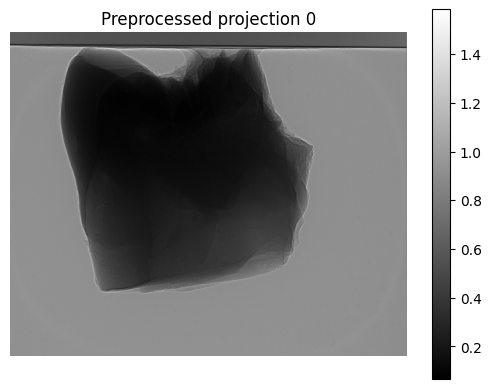

In [1]:
import numpy as np

def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

projs = np.load('test.npy')

display_slice(projs[0], title='Preprocessed projection 0', cmap='gray', colorbar=True)

Pixel size: 1.2e-05
Wavelength: 4.933174294500976e-12


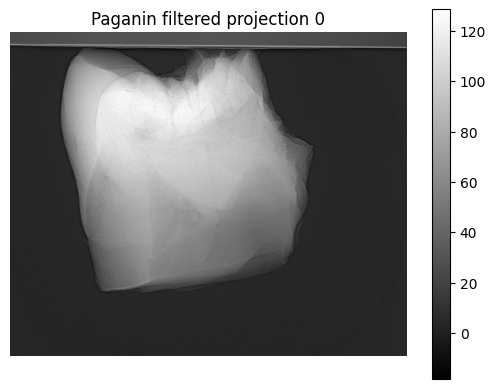

<Image layer 'projections' at 0x223a52f1490>

In [14]:
import math
from cupy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
from cupyx.scipy.ndimage import gaussian_filter, median_filter
import numpy as np
from tqdm import tqdm
import cupy as cp

from cupy import pi

import matplotlib.pyplot as plt

PLANCK_keV_S = 6.58211928e-19     # en J·s
LIGHT_SPEED = 2.99792458e8      # en m/s
KEV_TO_JOULE = 1.602176634e-16  # 1 keV = 1.602...e-16 J

def keVtoLambda(keV: float) -> float:
    """
    Convert energy in keV to wavelength in meters.
    """
    # E = keV * KEV_TO_JOULE                          # en J
    wavelength_m = (PLANCK_keV_S * LIGHT_SPEED) / keV   # en m
    return wavelength_m

def phase_retrieval(I: cp.ndarray, delta_beta: float, distance: float, energy: float, pixel_size: float) -> cp.ndarray:
    """
    Phase retrieval using Paganin's method. 
    Paganin et al. Journal of Microscopy, 2002.
    """
    wavelength = keVtoLambda(energy)  # en m
    # pixel_size = keVtoLambda(pixel_size)  # en m
    print('Pixel size:', pixel_size)
    print('Wavelength:', wavelength)
    ny, nx = I.shape
    u = fftfreq(nx, d=pixel_size)  # en m-1
    v = fftfreq(ny, d=pixel_size)  # en m-1
    U, V = cp.meshgrid(u, v, indexing='ij')  # en m-1
    I_fft = fft2(I)
    denominator = 1 + pi * wavelength * distance * delta_beta * (U**2 + V**2)

    phi_fft = I_fft / denominator
    img_real = cp.real(ifft2(phi_fft))  # en m-1
    return - cp.log(img_real) * delta_beta * 0.5

def get_padding_size(image: cp.ndarray, energy: float, effective_pixel_size: float, distance: float) -> int:
    """
    Get the padding size for the image using ANKAphase formula.
    Weitkamp et al. Journal of Synchrotron Radiation, 2013.
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)  # en m
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size ** 2))  # en pixels
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin
    nx_padded = int(2 ** math.ceil(math.log2(nx_margin)))  # en pixels
    ny_padded = int(2 ** math.ceil(math.log2(ny_margin)))  # en pixels
    return n_margin, nx_padded, ny_padded

def padding(image: cp.ndarray, energy: float, effective_pixel_size: float, distance: float) -> cp.ndarray:
    """
    Padding the image using ANKAphase formula.
    Weitkamp et al. Journal of Synchrotron Radiation, 2013.
    """
    ny, nx = image.shape
    _, nx_padded, ny_padded = get_padding_size(image, energy, effective_pixel_size, distance)
    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left
    padded_image = cp.pad(image, ((top, bottom), (left, right)), mode='reflect')
    return padded_image, nx_padded, ny_padded

def unsharp_mask(image: cp.ndarray, sigma: float, coeff: float) -> cp.ndarray:
    """
    Apply unsharp mask to the image.
    """
    blurred = gaussian_filter(image, sigma=sigma, mode='reflect')
    return (1 + coeff) * image - coeff * blurred

def clean_outliers(image: cp.ndarray, threshold=3, size=3) -> cp.ndarray:
    """
    Clean outliers in the image using median filter.
    """
    mean = cp.mean(image)
    std = cp.std(image)
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    outlier = (image < lower_bound) | (image > upper_bound)
    median_img = median_filter(image, size=size, mode='reflect')
    cleaned_img = image.copy()
    cleaned_img[outlier] = median_img[outlier]
    return cleaned_img

def process_projection(proj: np.ndarray, energy: float,pixel_size: float, effective_pixel_size: float, distance: float, delta_beta: float) -> np.ndarray:
    """
    Process the projection using Paganin's method.
    """
    ny, nx = proj.shape
    proj_cp = cp.asarray(proj)
    padded_proj, nx_padded, ny_padded = padding(proj_cp, energy, effective_pixel_size, distance)
    retrieved_proj = phase_retrieval(padded_proj, delta_beta, distance, energy, pixel_size)
    retrieved_proj = clean_outliers(retrieved_proj, threshold=3, size=3)
    x_margin = (nx_padded - nx) // 2
    y_margin = (ny_padded - ny) // 2
    return retrieved_proj[y_margin:y_margin + ny, x_margin:x_margin + nx].get()
    # return retrieved_proj.get()

def paganin_filter(projs: np.ndarray, energy: float, pixel_size: float, effective_pixel_size: float, distance: float, delta_beta: float) -> np.ndarray:
    """
    Apply Paganin filter to the projections.
    """
    retrieved_projs = np.zeros(projs.shape, dtype=np.float32)
    for i in tqdm(range(projs.shape[0]), desc='Processing Paganin'):
        retrieved_projs[i] = process_projection(projs[i],
                                energy, 
                                pixel_size, effective_pixel_size, 
                                distance, delta_beta)
    return {'paganin': retrieved_projs}

retrieve_proj = process_projection(projs[0], 40, 12e-6, 12e-6, 1.2, 100)

plt.figure()
display_slice(retrieve_proj, title='Paganin filtered projection 0', cmap='gray', colorbar=True)

import napari

viwer = napari.Viewer()
viwer.add_image(retrieve_proj, name='projections', colormap='gray')



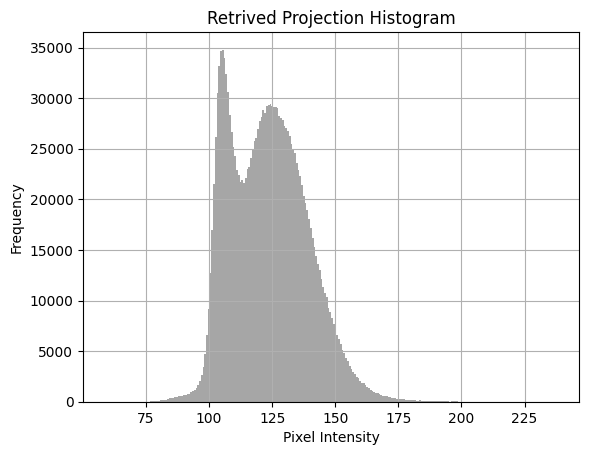

In [3]:
### Histogram
import matplotlib.pyplot as plt

def plot_histogram(image, title='Histogram', bins=256, range=None):
    """
    Plot the histogram of an image.

    Parameters:
    - image: 2D numpy array representing the image.
    - title: Title of the histogram plot.
    - bins: Number of bins for the histogram.
    - range: Range of values to consider for the histogram.

    Returns:
    - None
    """
    plt.hist(image.ravel(), bins=bins, range=range, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_histogram(retrieved_projs[0], title='Retrived Projection Histogram', bins=256)

In [4]:

### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos

CoR = 95.5
sinogram = create_sinogram(retrieved_projs, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)

### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

# reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]))
# for i in tqdm(range(sinogram.shape[0]), desc='Reconstructing'):
#     reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * disk_mask

reconstruction = reconstruct_from_sinogram_slice(sinogram[459], angles) * disk_mask

print("Reconstruction shape:", reconstruction.shape)

print('SNR:', compute_snr(reconstruction))

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Reconstruction')


Creating sinograms: 100%|██████████| 1200/1200 [00:06<00:00, 187.04it/s]


Sinogram shape: (1200, 1600, 2753)
Angles shape: [0.00000000e+00 1.96349541e-03 3.92699082e-03 ... 3.13570217e+00
 3.13766566e+00 3.13962916e+00]
Reconstruction shape: (2753, 2753)
SNR: 0.6604009818048618


napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Reconstruction' at 0x235d66ab6e0>

In [5]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction', colormap='gray')

<Image layer 'Reconstruction' at 0x235e430eab0>

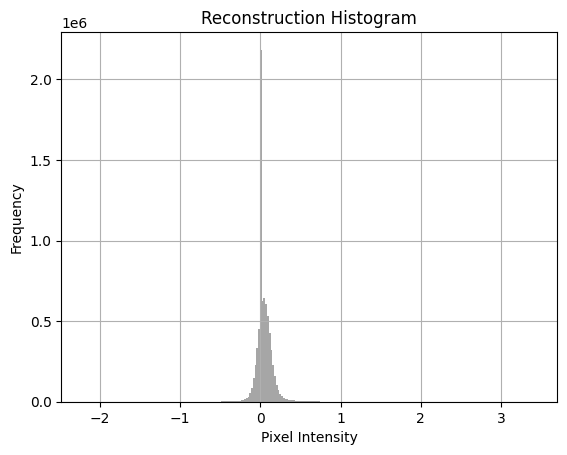

In [6]:
### Histogram
import matplotlib.pyplot as plt

def plot_histogram(image, title='Histogram', bins=256, range=None):
    """
    Plot the histogram of an image.

    Parameters:
    - image: 2D numpy array representing the image.
    - title: Title of the histogram plot.
    - bins: Number of bins for the histogram.
    - range: Range of values to consider for the histogram.

    Returns:
    - None
    """
    plt.hist(image.ravel(), bins=bins, range=range, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_histogram(reconstruction, title='Reconstruction Histogram', bins=256)

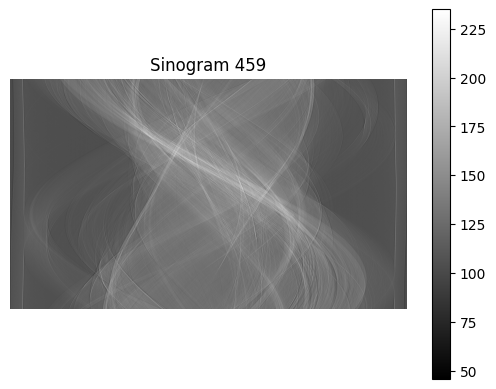

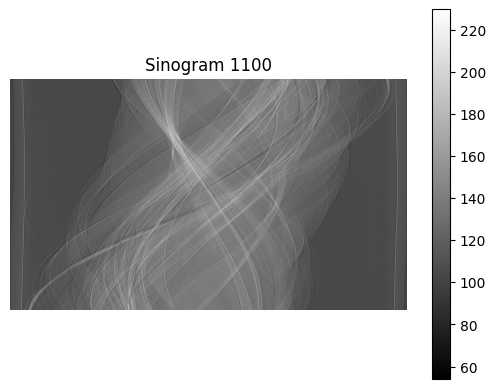

In [7]:
img1 = sinogram[459]
img2 = sinogram[1100]

display_slice(img1, title='Sinogram 459', cmap='gray', colorbar=True)
display_slice(img2, title='Sinogram 1100', cmap='gray', colorbar=True)

In [8]:
def get_std(img):
    return cp.std(cp.array(img))

def get_cv(img):
    return cp.std(cp.array(img)) / cp.mean(cp.array(img))

def compute_snr(img):

    signal = cp.asarray(img)
    noise = signal - cp.mean(signal)

    signal_power = cp.mean(signal ** 2)
    noise_power = cp.mean(noise ** 2)

    if noise_power == 0:
        return cp.inf
    return 10 * cp.log10(signal_power / noise_power)

def get_inv_snr(img):
    return 1 / compute_snr(cp.asarray(img))

print('Standarsd deviation info:', get_std(img1))
print('Standarsd deviation empty:', get_std(img2))
print('________________________________________________________')

print('Coefficient of variation info:', get_cv(img1))
print('Coefficient of variation empty:', get_cv(img2))
print('________________________________________________________')

print('SNR info:', compute_snr(img1))
print('SNR empty:', compute_snr(img2))
print('________________________________________________________')

print('Inverse SNR info:', get_inv_snr(img1))
print('Inverse SNR empty:', get_inv_snr(img2))
print('________________________________________________________')



Standarsd deviation info: 18.010090395539464
Standarsd deviation empty: 18.756923811282235
________________________________________________________
Coefficient of variation info: 0.14462845150369957
Coefficient of variation empty: 0.1519316178526667
________________________________________________________
SNR info: 16.88483128371615
SNR empty: 16.466146352532288
________________________________________________________
Inverse SNR info: 0.05922475523722923
Inverse SNR empty: 0.06073066390826852
________________________________________________________


In [9]:
std = []
cv = []
snr = []
inv_snr = []

for i in tqdm(range(sinogram.shape[0]), desc='Computing standard deviation'):
    std.append(get_std(sinogram[i]).get())
    cv.append(get_cv(sinogram[i]).get())
    snr.append(compute_snr(sinogram[i]).get())
    inv_snr.append(get_inv_snr(sinogram[i]).get())

Computing standard deviation: 100%|██████████| 1200/1200 [01:00<00:00, 19.82it/s]


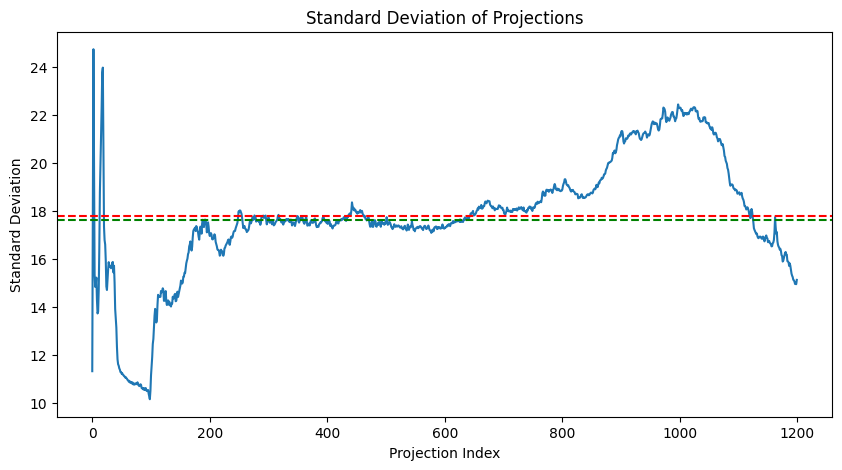

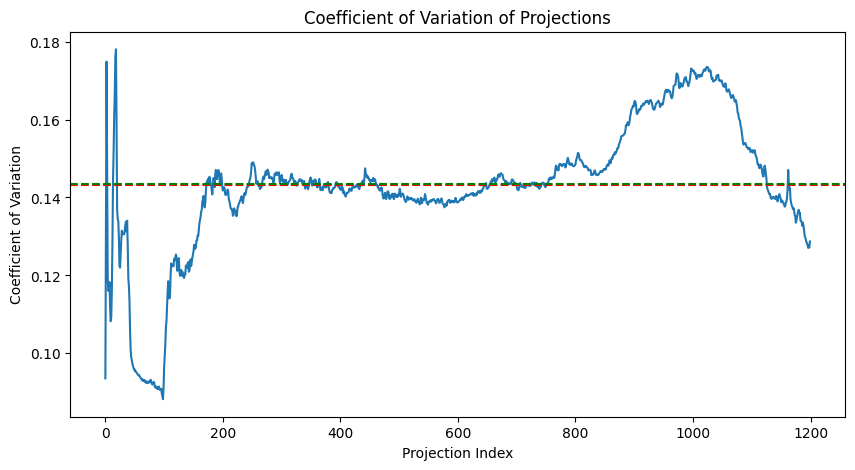

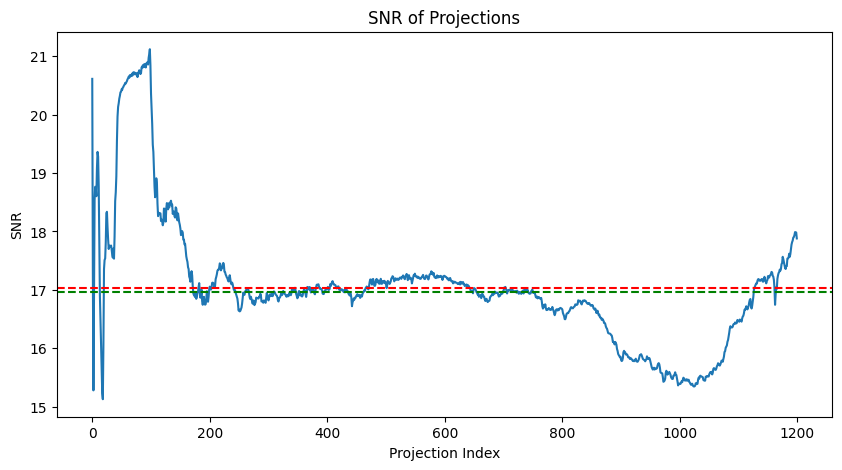

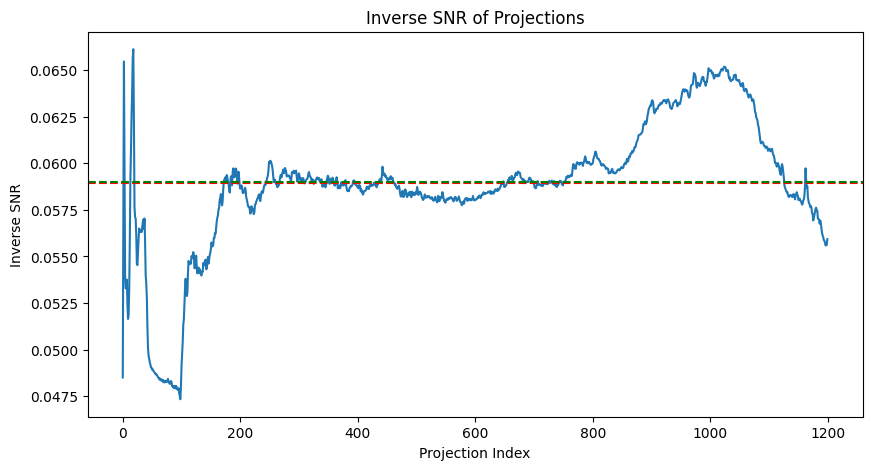

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(std, label='Standard Deviation')
plt.xlabel('Projection Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Projections')
plt.axhline(y=np.mean(std), color='r', linestyle='--', label='Mean')
plt.axhline(y=np.median(std), color='g', linestyle='--', label='Median')

plt.figure(figsize=(10, 5))
plt.plot(cv, label='Coefficient of Variation')
plt.xlabel('Projection Index')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation of Projections')
plt.axhline(y=np.mean(cv), color='r', linestyle='--', label='Mean')
plt.axhline(y=np.median(cv), color='g', linestyle='--', label='Median')

plt.figure(figsize=(10, 5))
plt.plot(snr, label='SNR')
plt.xlabel('Projection Index')
plt.ylabel('SNR')
plt.title('SNR of Projections')
plt.axhline(y=np.mean(snr), color='r', linestyle='--', label='Mean')
plt.axhline(y=np.median(snr), color='g', linestyle='--', label='Median')

plt.figure(figsize=(10, 5))
plt.plot(inv_snr, label='Inverse SNR')
plt.xlabel('Projection Index')
plt.ylabel('Inverse SNR')
plt.title('Inverse SNR of Projections')
plt.axhline(y=np.mean(inv_snr), color='r', linestyle='--', label='Mean')
plt.axhline(y=np.median(inv_snr), color='g', linestyle='--', label='Median')

Recherche du COR par ligne: 100%|██████████| 1200/1200 [04:59<00:00,  4.01it/s]


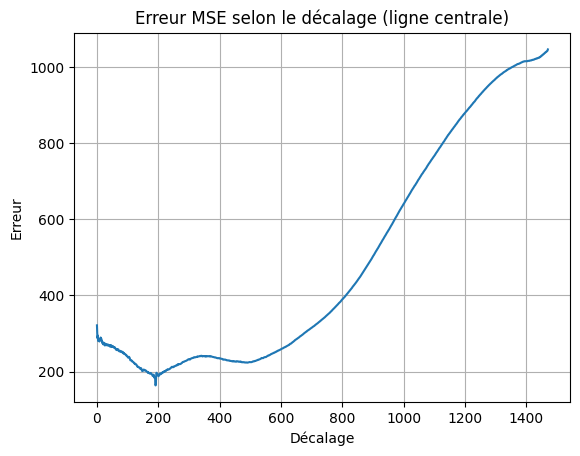

Centre estimé (ligne centrale) : 95.50 px
Centre moyen sur toutes les lignes : 95.25 px


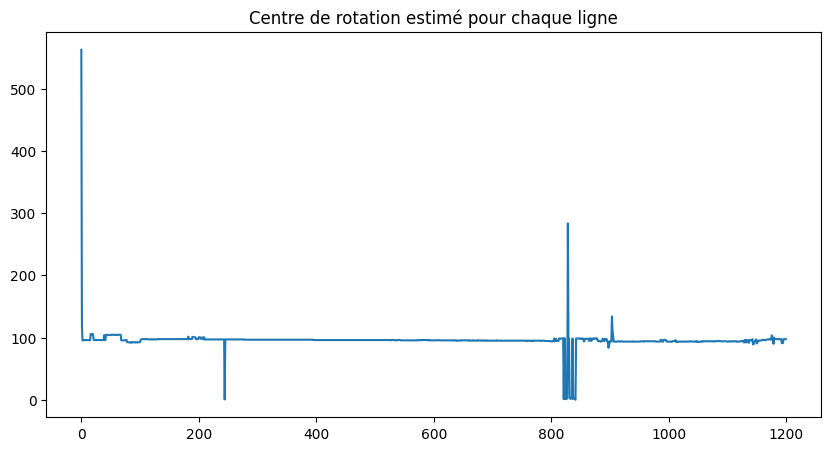

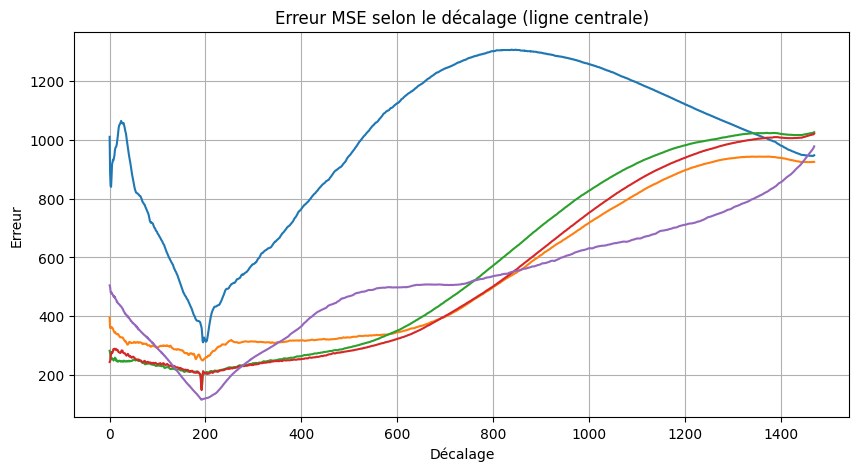

In [15]:
from numpy import random
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calc_cor_gpu(projs):
    """
    projs_cp: projections [angles, hauteur, largeur] (CuPy array)
    """
    theta, ny, nx = projs.shape
    start = 0
    stop = ny
    step = 1
    cor = cp.zeros((stop - start + step - 1) // step, dtype=cp.float16)  # Stocke les centres pour chaque ligne
    plot_data = []

    i = 0
    for y in tqdm(range(start, stop, step), desc="Recherche du COR par ligne"):
        # sinogramme d'une ligne horizontale
        sino1 = cp.asarray(projs[:theta // 2, y, ::-1])  # Première moitié inversée
        sino2 = cp.asarray(projs[theta // 2:, y, :])     # Deuxième moitié

        errors = cp.zeros(nx - 1, dtype=cp.float16)  # Stocke les erreurs pour chaque décalage
        for shift in range(1, nx):
            t1 = sino1[:, -shift:]
            t2 = sino2[:, :shift]
            if t1.shape != t2.shape:
                continue
            mse = cp.mean((t1 - t2) ** 2)
            errors[shift - 1] = mse

        best_shift = cp.argmin(errors)
        plot_data.append(errors.get())  # Convertit en NumPy pour le traçage
        cor[i] = (best_shift) / 2  # Position estimée du COR
        i += 1

    return cor.get(), plot_data  # Convertit `cor` en NumPy pour l'utilisation ultérieure

cor, plot = calc_cor_gpu(retrieved_projs)
# Affichage des résultats
plt.plot(plot[len(plot) // 2])  # Trace les erreurs pour la ligne centrale
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

print(f"Centre estimé (ligne centrale) : {cor[len(cor) // 2]:.2f} px")
print(f"Centre moyen sur toutes les lignes : {np.mean(cor):.2f} px")

plt.figure(figsize=(10, 5))
plt.plot(cor)
plt.title("Centre de rotation estimé pour chaque ligne")

plt.figure(figsize=(10, 5))
list = random.choice(range(len(plot)), 5)
for i in list:
    plt.plot(plot[i])
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

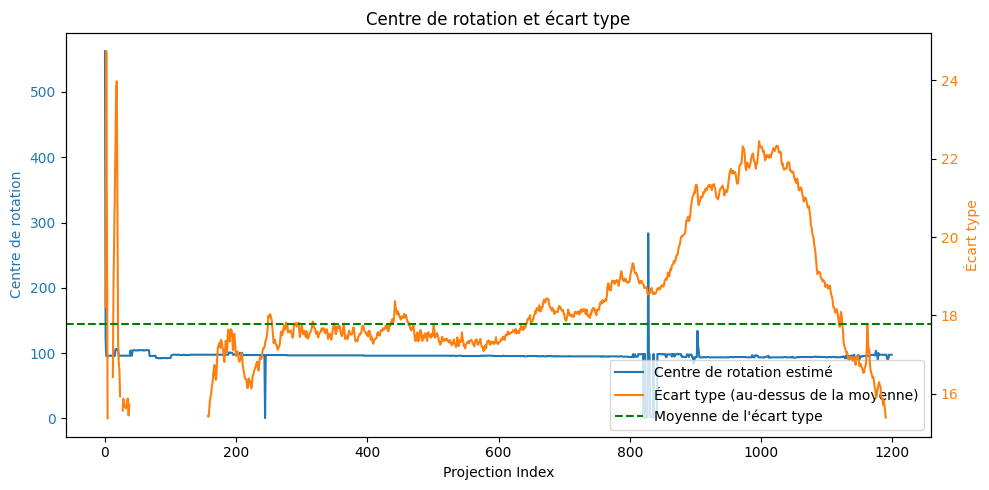

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 5))

# Centre de rotation
ax1.plot(cor, color='tab:blue', label='Centre de rotation estimé')
ax1.set_ylabel("Centre de rotation", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Deuxième axe Y pour std
ax2 = ax1.twinx()

# Masquage des valeurs en dessous ou égales à la moyenne
std_above_mean = np.where(std > np.mean(std) - np.std(std), std, np.nan)

# Tracé seulement des valeurs au-dessus de la moyenne
ax2.plot(std_above_mean, color='tab:orange', label="Écart type (au-dessus de la moyenne)")
ax2.axhline(y=np.mean(std), color='green', linestyle='--', label="Moyenne de l'écart type")
ax2.set_ylabel("Écart type", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Axe X et titre
ax1.set_xlabel("Projection Index")
plt.title("Centre de rotation et écart type")

# Fusion des légendes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()


In [20]:
# Filtrage des indices où std est supérieur à sa moyenne
mask = std > np.mean(std) - np.std(std)

# Calcul de la moyenne de cor seulement pour ces indices
mean_cor_filtered = np.mean(cor[mask])
print("Moyenne du centre de rotation (pour std > moyenne) :", mean_cor_filtered)


Moyenne du centre de rotation (pour std > moyenne) : 94.5


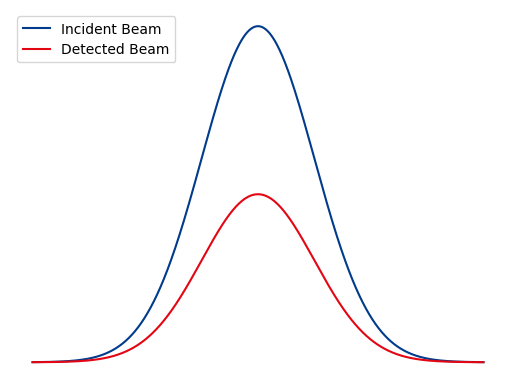

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Paramètres
mu = 2
sigma1 = 10
sigma2 = 10

# Données
x = np.linspace(mu - 4*sigma1, mu + 4*sigma1, 1000)
y1 = norm.pdf(x, mu, sigma1)
y2 = 0.5 * norm.pdf(x, mu, sigma2)  # même sigma, mais amplitude divisée par 2

# Tracé
plt.plot(x, y1, color='#003b8c', label='Incident Beam')
plt.plot(x, y2, color='#e30613', label='Detected Beam')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.legend(loc='upper left')
plt.show()


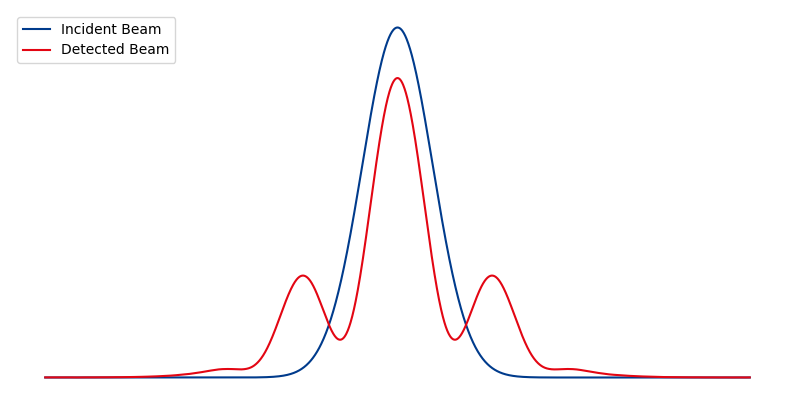

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Grille 1D
N = 2048
L = 10.0  # mm
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]

# Paramètres physiques
λ = 0.01   # mm
z = 200.0  # mm
w0 = 1.0   # largeur du faisceau

# Faisceau gaussien
amplitude = np.exp(-x**2 / w0**2)

# Objet : une petite zone qui modifie la phase
# Par exemple, une gaussienne centrée en x = 0
phase = np.pi * np.exp(-x**2 / 0.5**2)  # bump de phase
U0 = amplitude * np.exp(1j * phase)

# Propagation de Fresnel
fx = np.fft.fftfreq(N, d=dx)
H = np.exp(-1j * np.pi * λ * z * fx**2)
U0_fft = np.fft.fft(U0)
Uz = np.fft.ifft(U0_fft * H)

# Intensité après propagation
I = np.abs(Uz)**2

# Affichage
plt.figure(figsize=(10, 5))
plt.plot(x, np.abs(U0)**2, label="Incident Beam", color='#003b8c')
plt.plot(x, I, label="Detected Beam", color='#e30613')

plt.xticks([])
plt.yticks([])
plt.box(False)
plt.legend(loc='upper left')
plt.show()
